In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json
from core.kohonen import Kohonen

config_file = "../configs/kohonen.json"

with open(config_file) as f:
    config = json.load(f)

europe_data = pd.read_csv(config['data']['source'])
df = europe_data[config['data']['features']]
scaler = StandardScaler()
data = scaler.fit_transform(df.values) # we need to scale the data
#print(data.shape) # we've got 28 elements with 7 features
#print(data)
weights = None

In [2]:


som = Kohonen(
    data=data,
    grid_size=config['kohonen']['grid_size'],
    learning_rate=config['kohonen']['learning_rate'],
    eta_function=config['kohonen']['eta_function'],
    radius=config['kohonen']['initial_radius'],
    radius_function=config['kohonen']['radius_function'],
    similarity_function=config['kohonen']['similarity_function'],
    seed=config['kohonen']['seed'],
    weights=weights
)

som.train(num_iterations=config['kohonen']['number_of_iterations'])

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def map_countries_to_bmus(data, kohonen_net: Kohonen):
    bmu_mapping = {}
    for i, sample in enumerate(data):
        bmu = kohonen_net.find_bmu(sample)
        country_name = europe_data['Country'].iloc[i]
        if bmu not in bmu_mapping:
            bmu_mapping[bmu] = [country_name]
        else:
            bmu_mapping[bmu].append(country_name)
    return bmu_mapping

bmu_mapping = map_countries_to_bmus(data, som)

bmu_mapping


{(3, 4): ['Austria', 'Denmark'],
 (2, 4): ['Belgium'],
 (0, 0): ['Bulgaria', 'Estonia', 'Latvia', 'Ukraine'],
 (0, 2): ['Croatia'],
 (3, 2): ['Czech Republic'],
 (4, 0): ['Finland', 'Spain'],
 (4, 1): ['Germany'],
 (0, 3): ['Greece', 'Portugal'],
 (1, 1): ['Hungary'],
 (4, 4): ['Iceland',
  'Ireland',
  'Luxembourg',
  'Netherlands',
  'Norway',
  'Switzerland'],
 (4, 2): ['Italy', 'Sweden'],
 (1, 0): ['Lithuania'],
 (2, 0): ['Poland'],
 (2, 1): ['Slovakia'],
 (0, 4): ['Slovenia', 'United Kingdom']}

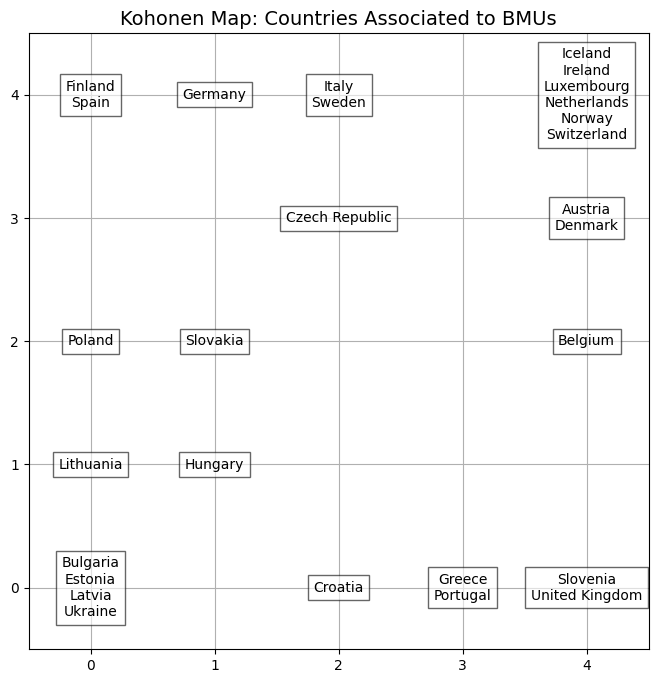

In [4]:
plt.figure(figsize=(8, 8))
plt.title('Kohonen Map: Countries Associated to BMUs', fontsize=14)
plt.xlim(-0.5, config['kohonen']['grid_size'] - 0.5)
plt.ylim(-0.5, config['kohonen']['grid_size'] - 0.5)

for bmu, countries in bmu_mapping.items():
    plt.text(bmu[1], bmu[0], '\n'.join(countries), ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.grid(True)
plt.gca()
plt.show()


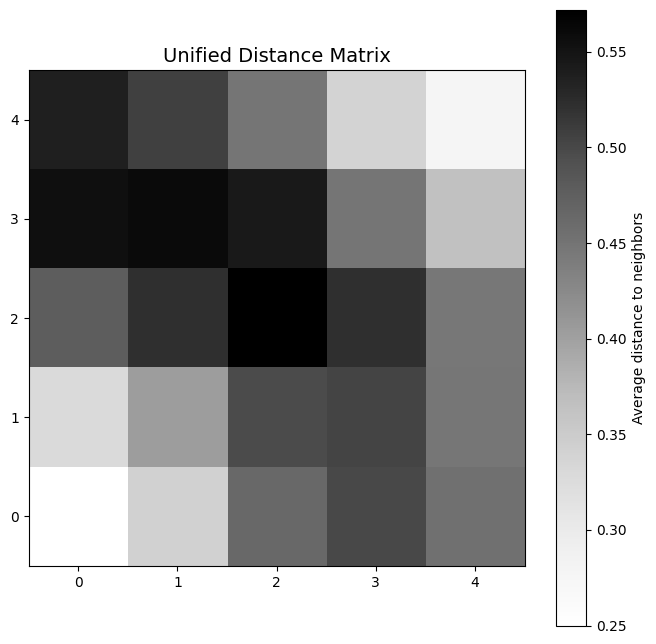

In [5]:
def plot_umatrix(u_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(u_matrix, cmap='Greys', origin='lower')  
    plt.colorbar(label='Average distance to neighbors')
    plt.title('Unified Distance Matrix', fontsize=14)
    plt.show()

u_matrix = som.calculate_umatrix()
plot_umatrix(u_matrix)


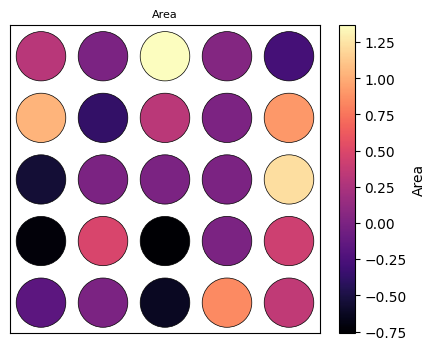

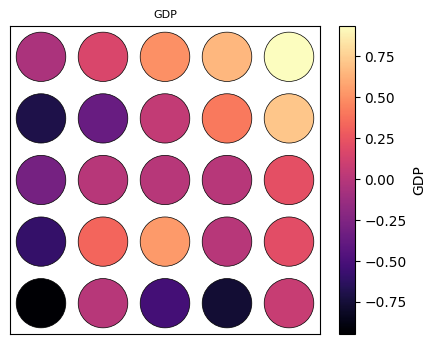

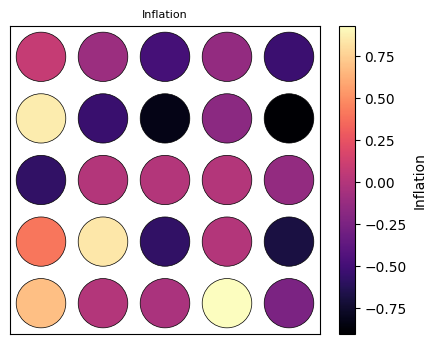

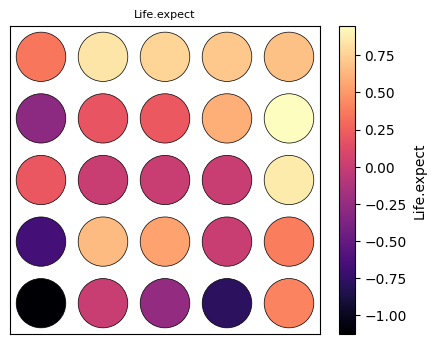

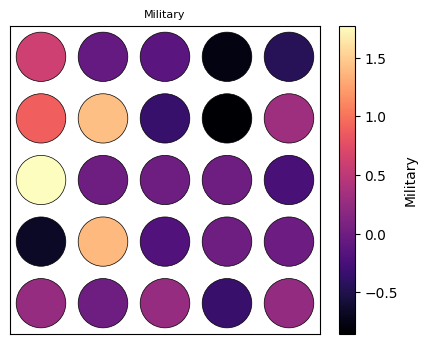

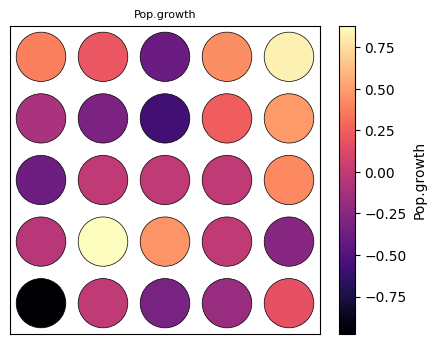

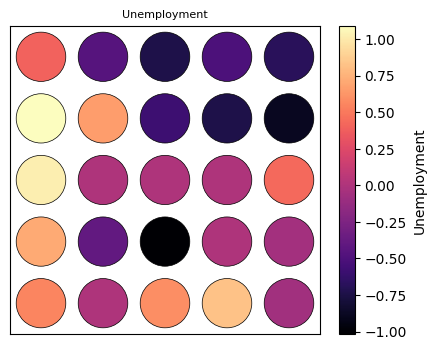

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def plot_variable_on_kohonen_grid(kohonen: Kohonen, variable_matrix, variable_name):
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.title(f'{variable_name}', fontsize=8)
    plt.xlim(-0.5, kohonen.grid_size - 0.5)
    plt.ylim(-0.5, kohonen.grid_size - 0.5)

    norm = mcolors.Normalize(vmin=np.min(variable_matrix), vmax=np.max(variable_matrix))

    for i in range(kohonen.grid_size):
        for j in range(kohonen.grid_size):
            color = plt.cm.magma(norm(variable_matrix[i, j]))  # Color based on variable value
            circle = plt.Circle((j, i), 0.4, color=color, ec='black', lw=0.5)
            ax.add_patch(circle)

    sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(variable_name)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.gca()
    plt.show()

def plot_all_features(kohonen: Kohonen, config):
    feature_names = config['data']['features'] 
    
    for i, feature_name in enumerate(feature_names):
        variable_matrix = kohonen.calculate_variable_matrix(feature_column=i)
        
        plot_variable_on_kohonen_grid(kohonen, variable_matrix, feature_name)


plot_all_features(som, config)


/tmp/ipykernel_2337301/1976950902.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))


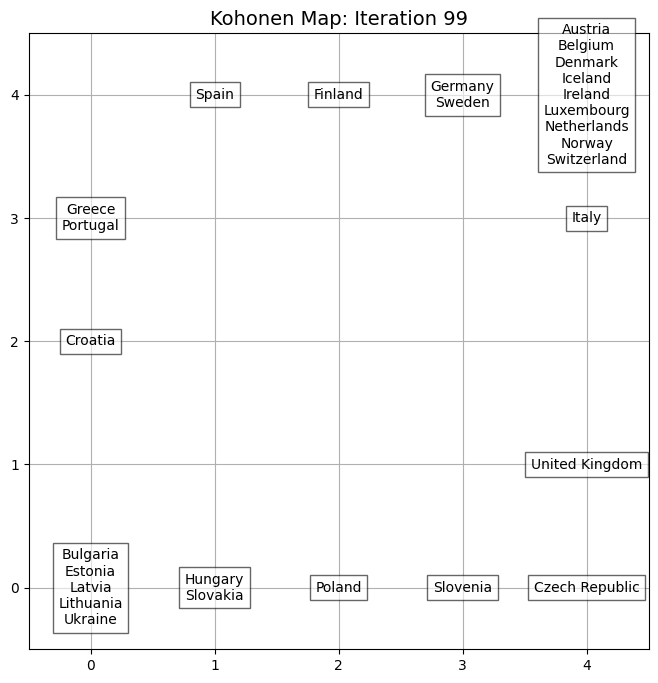

In [7]:
import matplotlib.pyplot as plt
import imageio
import numpy as np

def plot_kohonen_map(kohonen_net, bmu_mapping, iteration, ax):
    ax.clear()
    ax.set_title(f'Kohonen Map: Iteration {iteration}', fontsize=14)
    ax.set_xlim(-0.5, kohonen_net.grid_size - 0.5)
    ax.set_ylim(-0.5, kohonen_net.grid_size - 0.5)

    for bmu, countries in bmu_mapping.items():
        ax.text(bmu[1], bmu[0], '\n'.join(countries), ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    ax.grid(True)

def generate_kohonen_training_gif(kohonen_net, num_iterations, capture_interval, bmu_mapping_func):
    fig, ax = plt.subplots(figsize=(8, 8))
    frames = []

    for iteration in range(num_iterations):
        sample = kohonen_net.input_data[np.random.randint(kohonen_net.input_data.shape[0])]
        bmu = kohonen_net.find_bmu(sample)
        kohonen_net.update_weights(sample, bmu, iteration, num_iterations)

        if iteration % capture_interval == 0:
            bmu_mapping = bmu_mapping_func(kohonen_net.input_data, kohonen_net)
            plot_kohonen_map(kohonen_net, bmu_mapping, iteration, ax)

            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(image)

    gif_path = '../assets/kohonen_map_evolution.gif'
    imageio.mimsave(gif_path, frames, duration=2)
    return gif_path

def map_countries_to_bmus(data, kohonen_net):
    bmu_mapping = {}
    for i, sample in enumerate(data):
        bmu = kohonen_net.find_bmu(sample)
        country_name = europe_data['Country'].iloc[i]
        if bmu not in bmu_mapping:
            bmu_mapping[bmu] = [country_name]
        else:
            bmu_mapping[bmu].append(country_name)
    return bmu_mapping

num_iterations = 100
capture_interval = 1  
gif_path = generate_kohonen_training_gif(som, num_iterations, capture_interval, map_countries_to_bmus)



In [8]:
# Realizar un gr´afico que muestre las distancias promedio entre neuronas vecinas.
# Analizar la cantidad de elementos que fueron asociados a cada neurona.


average_distance = som.calculate_average_neighbor_distances()
print(f"Average distance between neighboring neurons: {average_distance}")

import matplotlib.pyplot as plt
import numpy as np
import imageio

def create_bmu_count_gif(bmu_count_history, filename="bmu_count.gif", interval=0.5):
    frames = []
    for i, bmu_count in enumerate(bmu_count_history):
        fig, ax = plt.subplots()
        
        im = ax.imshow(bmu_count, cmap='magma')
        plt.colorbar(im, label='Number of elements')
        plt.title(f'Number of countries per each neuron - Iteration {i}')
        
        norm = plt.Normalize(vmin=np.min(bmu_count), vmax=np.max(bmu_count))
        
        for x in range(bmu_count.shape[0]):
            for y in range(bmu_count.shape[1]):
                color_value = norm(bmu_count[x, y])
                text_color = 'white' if color_value < 0.5 else 'black'
                
                ax.text(y, x, int(bmu_count[x, y]), ha='center', va='center', color=text_color)

        fig.canvas.draw()  
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        
        frames.append(image)
        plt.close(fig)
    
    imageio.mimsave(f"../assets/{filename}", frames, duration=interval)

bmu_count_history = som.bmu_count_history

create_bmu_count_gif(bmu_count_history)


Average distance between neighboring neurons: 0.42875196765244017
